**CONTENT**

In this notebook we will create stochastic simulations based on either `COVID19_SEIRD_sto` or `COVID19_SEIRD_sto_spatial` with various *initial conditions* and *imposed measures*.

**OPEN TASKS**

*short term*
1. ~~Define some interesting realistic and/or artificial initial conditions~~
2. Define some interesting realistic and/or artificial imposed measures: See Tijs' preprint
3. ~~Initiate the models and create a readable environment to make nice plots (create some definitions?)~~
4. ~~Compare the dynamics and results of the spatially stratified model with the national model (these should largely correspond with each other)~~
5. Choose the most pertinent conditions and measures for plotting in geopandas and make a full-resolution video of the simulation
6. ~~Plot infections, hospitalisations and deaths~~
7. *Important*: Compare with actual data (See `MR-time-series-correlation` in `/spatial_private`)
8. ~~Automate the hard-code in `models.py` line `coordinates = [read_coordinates_nis(spatial='test')]`~~
9. ~~Find a nice way to show upper and lower percentiles~~
10. ~~Define functions in a `visualization` environment. That should make it much more readable~~ in `output`
11. ~~Make a Pull Request~~ Make another one
12. **Calibrate the results on the actual data. IDEA: can't we also calibrate on the effect of measures --> see how measures were *actually* followed? Right now this seems like a big estimation.**
13. ~~In `show_map`, include meaning of uncertainty band in legend if only one line is shown~~
14. Define `social_policy_func` in `utils.py`
15. ~~Find a way to save `xarray` objects~~
16. Add social parameters `l` and `tau` to the default fetched parameters
17. ~~Make the plotting device at the end of the Notebook into a function~~
18. Find a way to also easily plot Sciensano data with the same functions
19. Include relative (per 100k) numbers
20. Verify that `show_maps` works fine for xarrays that have no draws

*long term*  
2. Take out the most relevant results and summarise in a $\LaTeX$ presentation
3. Include age-stratification for the mobility matrix $P^{gh}$
4. **Include spatial stratification for the mobility parameter $p_i$: simulate negative travel advice**
5. Include age stratification for *all* hospital parameters (including average number of days in the hospital)
6. Visualise the measures
7. Include framework for vaccination
8. Allow for fractional infection from mildly symptomatic people that ignore safety regulations (self-isolation), preferably based on research
9. Show age distribution in the relevant time series at any time: add this to function.
10. Fix the percentile problem: right now we are taking the percentiles for every time value, but independent simulations might cross each other. This is therefore not strictly correct (this is a detail though)
11. In the `show_map` function, include age stratification.
12. Add 'smooth-out' option (7-day moving average) to show_maps and show_graphs functions, as is done in the actual data

**OPEN QUESTIONS**

1. What is the reason for and the meaning of the normalisation factor $z_i$ in `COVID19_SEIRD_sto_spatial`?
2. Is it OK for all susceptibility factors $s_i$ to be smaller than one, as is the case now? Not a big deal, but seems odd and certainly changes the $\beta$ value (such that it doesn't correspond to that of other research groups)
3. Can we simulate home isolation within this framework? If the contact matrix $N_{c,ij}$ is set to only $N_{home,ij}$, this still assumes homogeneity within each patch. One than still has contact with the entire patch, which is not realistic
4. Only professional commuting is included, but presumably this is not sufficient. Can we use these simulations to verify that? **MEETING 29 OCTOBER**
5. ~~Why are there so few hospitalisations compared to the number of deaths? There is definitely a bug there somewhere: the number of ICUs is even larger than the number of hospitalisations, which cannot be correct.~~
    * Probably because `H_in` literally shows how many new people get in at any day (flux only), while for example `ICU` shows how many people are *actively* occupying ICU beds. Of course there is a crucial difference between the two.
6. ~~Why does it take SOOO much longer to compute the national model vs the spatial model? Verify whether this is a factor $G$ difference~~ Reason: the figure environment should be reloaded every time, otherwise the figures are overwritten, which takes a lot of memory.
7. All numbers go up in the aggregated version compared to the national model. I would actually expect the opposite, because people aren't spread as homogenic as before. What is going on? This must be **the effect of the normalisation** ...but wouldn't this give the opposite effect? $z_i \times f$ is of the order $0.5 \times 1.5$ which brings *down* the infectivity, which lowers the probability of being infected in a patch $g$. So if anything, I would expect the time series to be smaller than on the national level.
8. How do I implement multiple policy changes?
9. In the deterministic model, the integrate function outputs the *change* in the state, while in the stochastic model it returns the new values. That is very weird, right?
    * This is the nature of the `Discrete = True` statement in the model initialisation
10. ~~Issue with the integration in the determinstic spatial model: the input for the initial value problem has too many dimension: ``y0 must be 1-dimensional``.~~
11. WHY OH WHY doesn't the spatial model converge to the national one? I really do not think it's the formulation in `models.py`, that looks good. Neither is it the initial condition, nor the 'Arenas factor'.

# Load packages

In [1]:
# Established packages
import os
import numpy as np
import pandas as pd
import geopandas as gp
import datetime
import math
import xarray as xr # labels in the form of dimensions, coordinates and attributes
import matplotlib.pyplot as plt
import zarr

# Custom package covid19model
from covid19model.models import models
from covid19model.models.utils import name2nis, save_sim, open_sim
from covid19model.data import model_parameters #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import social_policy_func


# Load different geographical aggregations
maps_dir = '../data/raw/geopandas/BE/'

country = gp.read_file(os.path.join(maps_dir, 'AD_6_Country.shp'))
regions = gp.read_file(os.path.join(maps_dir, 'AD_5_Region.shp'))
provinces = gp.read_file(os.path.join(maps_dir, 'AD_4_Province.shp'))
arrondissements = gp.read_file(os.path.join(maps_dir, 'AD_3_District.shp'))
municipalities = gp.read_file(os.path.join(maps_dir, 'AD_2_Municipality.shp'))
testgeo = arrondissements.loc[arrondissements['NISCode'].isin(['11000', '21000', '44000'])].reset_index(drop=True)
# Add NIS-code to Arrondissement Brussel-Hoofdstad
provinces.loc[provinces['NISCode']=='NA', 'NISCode'] = '21000'


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Content and initialisation

## Oversight of various model conditions

Any of the conditions below are implemented for both the spatial and the national stochastic SEIRD-extended model.

**Initial conditions**
1. One exposed person on day 0. With some spatial variation:  
    1. On the far southeast side of the country  
    2. On the far northwest side of the country  
    3. In Brussels  
2. Fifty exposed people on day 0, same spatial variation
3. Only asymptomatic people instead of exposed people
4. Only presymptomatic people instead of exposed people
5. No mobility whatsoever (sanity check, can only be done in spatial model)

**Measures**
1. Decrease overall contact parameter: type of contact stays the same, but the frequency is lowered
2. Change *type* of contact: only remain home contact (but note that this does not mean that families are isolated!)
3. Decrease mobility between cities (can only be done in spatial model)
4. Vaccination: migrate the number of Susceptible straight to the Recovered category

**Spatial levels**
1. 'Test' level: only arrondissements Antwerpen, Brussel, Gent
2. Arrondissement level: 43 arrondissements
3. Province level: 10+1 provinces
4. National level: no spatial stratification

## Initialisation of common parameters

In [2]:
# ---------------------------- #
# Choose simulation parameters #
# ---------------------------- #

# Note that a high number of simulations is computationally expensive, especially for high spatial stratification
sim_number = 100
days_number = 100

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number
tau = 5 # days until new measures show some effect
l = 5 # days since policy_time + tau until new measures show full effect

# Sanity check: correspondence between spatial model and national model

Below we load *a single exposed 35 year old individual* in every arrondissement (43 exposed people). We compare the resulting time series with those from simulations from the model stratified per province (4 per province+Bxl), and from the national model (43 in Belgium). Ideally, these should show identical dynamics.

**Results**
1. The simulations on province level and on arrondissement level are virtually identical.
2. The national model predicts gives many *fewer* hospitalisations.

**Discussion**
1. It is still unclear what the prefactors $f_i$ and $z_i$ mean. These influence the effective $\beta$, hence influencing the speed of the infection.
2. Currently $\beta$ is effectively *smaller* for the spatial model, so I don't understand why the infection spreads faster than in the national model
3. Perhaps I should spread the infected people out more according to population density (so more in Brussels and fewer in Arlon)

**Save simulation results in zarr**

In [166]:
# Name of the zarr directory in which the simulations are to be saved
zarr_dir = '../data/simulated/'
zarr_name = "Sanity-check_" + str(sim_number) + "sims_" + str(days_number) + \
                    "days_" + "Nctot-to-Nchome-day" + str(policy_time) + '.zarr'

zarr = zarr_dir + '/' + zarr_name

## Spatial model on arrondissement level

### Prepare the simulation

In [4]:
# Name of the zarr gropu in which this particular simulation is or will be saved
group = "arr_1E-per-arr"

# Load parameters and interaction matrices
age_str = True
spatial_str = 'arr'
intensity='all'
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

In [5]:
# Define initial conditions

# Every arrondissements gets one 35-year-old exposed individual
exposed = np.zeros(initN.shape)
for arr in exposed:
    arr[3] = 10
init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduce from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

In [6]:
# Load the model
model = models.COVID19_SEIRD_sto_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=True, spatial='arr')

### Run and save the simulations - WARNING: computationally expensive (only do once)

In [43]:
# Group name and output description
description = f"Stochastic spatial SEIRD extended model with {sim_number} "\
                    f"parallel simulations in 43 arrondissements over {days_number} days."\
                    f"At day 0 a single exposed person in the age class 30-40 is released in"\
                    f"each of the arrondissements. At day {policy_time} measures are imposed, "\
                    f"bringing down the contact rate from Nc_total to Nc_home over the course of "\
                    f"{tau} + {l} days (tau and l compliance parameters) reaches full effect."

# Perform simulation (commented out for safety)
# WARNING! First check if there isn't already data available for this simulation!
# out_sanity_arr = model.sim(days_number, N=sim_number, verbose=True)

# Save simulation results
# save_sim(out_sanity_arr, zarr, group, descr=description)

### Inspect the results

In [ ]:
# Load the simulation data
out_sanity_arr = open_sim(zarr, group, verbose=False)

In [ ]:
# Show map of a snapshot and the graphs of the major urban hubs (Antwerp, Brussels, Ghent)
day = 60
ts_geo = 'E'
ts_graph = ['E', 'ICU', 'D']
nis = [11000, 21000, 44000]
geomap, graphs = show_map(out_sanity_arr, arrondissements, ts_geo=ts_geo, day=day, ts_graph=ts_graph)

In [ ]:
figname = "sanity_arr_50sim_E-Hin-ICU-D.jpg"
graphs = show_graphs(out_sanity_arr, ylim=[30000, 200, 400, 500])#, figname=figname)

## Spatial model on province level

### Prepare the simulation

In [ ]:
# Name of the zarr gropu in which this particular simulation is or will be saved
group = "prov_4E-per-prov"

# Load parameters and interaction matrices
age_str = True
spatial_str = 'prov'
intensity='all'
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

In [ ]:
# Define initial conditions

# Every province gets four 35-year-old exposed individuals
exposed = np.zeros(initN.shape)
for prov in exposed:
    prov[3] = 4
init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduce from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

In [ ]:
# Load the model
model = models.COVID19_SEIRD_sto_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=True, spatial='prov')

### Run and save the simulations - WARNING: computationally expensive (only do once)

In [ ]:
# Group name and output description
description = f"Stochastic spatial SEIRD extended model with {sim_number} "\
                    f"parallel simulations in 10+1 provinces over {days_number} days. "\
                    f"At day 0 four exposed people in the age class 30-40 are released in "\
                    f"each of the provinces + Brussels-Capital. At day {policy_time} measures are imposed, "\
                    f"bringing down the contact rate from Nc_total to Nc_home. Over the course of "\
                    f"{tau} + {l} days (tau and l parameters) compliance reaches full effect."

# Perform simulation (commented out for safety)
# WARNING! First check if there isn't already data available for this simulation!
# out_sanity_prov = model.sim(days_number, N=sim_number, verbose=True)
out_sanity_test = model.sim(days_number, N=3, verbose=True)

out_sanity_test

# Save simulation results
# save_sim(out_sanity_prov, zarr, group, descr=description)

### Inspect the results

In [ ]:
# Load the simulation data
out_sanity_prov = open_sim(zarr, group)

In [ ]:
# Show map of a snapshot and the graphs of the major urban hubs (Antwerp, Brussels, Ghent)
day = 60
ts_geo = 'E'
ts_graph = ['E', 'ICU', 'D']
nis = [10000, 21000, 40000]
geomap, graphs = show_map(out_sanity_prov, provinces, ts_geo=ts_geo, day=day, ts_graph=ts_graph)

In [ ]:
graphs = show_graphs(out_sanity_prov, ylim=[30000, 200, 400, 500], figname="sanity_prov_50sim_E-Hin-ICU-D.jpg")

## National model

### Prepare the simulation

In [ ]:
# Name of the zarr gropu in which this particular simulation is or will be saved
group = "nat_43E"

# Load parameters and interaction matrices
age_str = True
intensity='all'
# spatial_str has been left out here
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity)

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

In [ ]:
# Define initial conditions

# The entire country gets 43 35-year-old exposed individuals
exposed = np.zeros(initN.shape)
exposed[3] = 43
init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduce from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

In [ ]:
# Load the model
model = models.COVID19_SEIRD_sto(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=True)

### Run and save the simulations - WARNING: computationally expensive (only do once)

In [ ]:
# Group name and output description
description = f"Stochastic national SEIRD extended model with {sim_number} "\
                    f"parallel simulations over {days_number} days. "\
                    f"At day 0 43 exposed people in the age class 30-40 are released homogeneously distributed "\
                    f"over the whole of Belgium. At day {policy_time} measures are imposed, "\
                    f"bringing down the contact rate from Nc_total to Nc_home. Over the course of "\
                    f"{tau} + {l} days (tau and l parameters) compliance reaches full effect."

# Perform simulation (commented out for safety)
# WARNING! First check if there isn't already data available for this simulation!
# out_sanity_nat = model.sim(days_number, N=sim_number, verbose=True)

# Save simulation results
# save_sim(out_sanity_nat, zarr, group, descr=description)

### Inspect the results

In [ ]:
# Load the simulation data
out_sanity_nat = open_sim(zarr, group)

In [ ]:
graphs = show_graphs(out_sanity_nat,ylim=[30000, 200, 400, 500])

# Demonstrating the spatial effect

Here the power of the spatial model is shown by dropping 5 infected patients in 'the middle of nowhere' and seeing how their disease spreads through Belgium.

The mean purpose here is to communicate the working of the simulation

**Result**  
Can be seen as an mp4 in the archives (Downloads folder at the moment)

**Discussion**  
1. This looks realistic
2. Would be interesting to treat these results as mock data and perform data analysis on these
3. Arguably more interesting to show the relative impact rather than the absolute impact

## Prepare the simulation

In [ ]:
# Load parameters and interaction matrices
age_str = True
intensity='all'
spatial_str = 'arr'
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

In [ ]:
# Define initial conditions

# Put 5 35 year-old exposed people in Arlon (index 35)
exposed = np.zeros(initN.shape)
exposed[35,3] = 5
init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduce from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

In [ ]:
# Load the model
model = models.COVID19_SEIRD_sto_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=True)

## Run the simulation - Warning: computationally expensive

In [ ]:
# Commented out for safety

out_demo_arr = model.sim(days_number, N=sim_number, verbose=True)

## Inspect the results

In [ ]:
# Make a video: see archives

ts_geo = 'E'
ts_graph = ['E', 'ICU', 'D']
nis = [81000, 21000, 31000] # Arlon, Brussel, Brugge

# Commented out for safety

# for day in range(days_number+1):
#     figname = f"demo_arr_5-35-yo_81000_day{day}.jpg"
#     maps, graphs = show_map(out_demo_arr, arrondissements, ts_geo=ts_geo, day=day, ts_graph=ts_graph, figname=figname)

## Plotting in graph

# Deterministic model explorations

--Pay attention!-- `Discrete` must be `False` in this case!

## National deterministic

In [172]:
# Load parameters and interaction matrices
age_str = True
spatial_str = None
intensity='all'

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity)

days_number = 100

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number
tau = 5 # days until new measures show some effect
l = 5 # days since policy_time + tau until new measures show full effect

In [174]:
# Define initial conditions

# Drop ten exposed 35-year-olds
exposed = np.zeros(initN.shape)
exposed[3] = 44

init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduced from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

params['beta']

0.03492

In [175]:
# Load the model
model = models.COVID19_SEIRD(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=False, spatial=spatial_str)

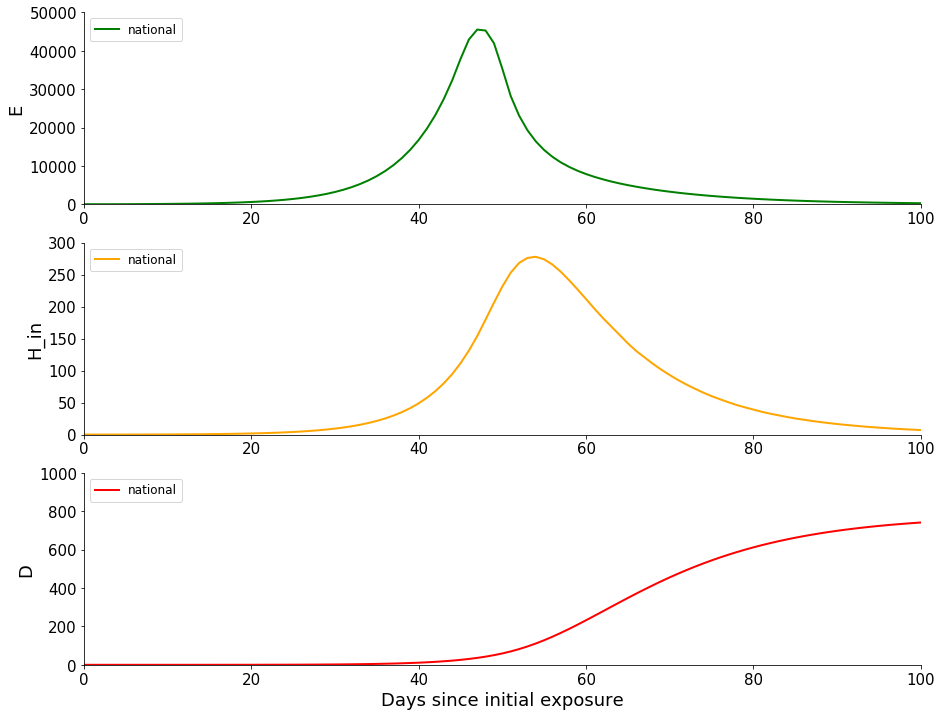

In [176]:
out_nat_det = model.sim(days_number)
graphs = show_graphs(out_nat_det, ylim=[50000, 300, 1000], ts=['E', 'H_in', 'D'])

In [52]:
out_nat_det['D'].sum(dim='Nc')

<xarray.DataArray 'D' (time: 101)>
array([0.00000000e+00, 6.41748722e-09, 6.58287179e-07, 9.02163299e-06,
       5.46932086e-05, 2.13025884e-04, 6.26937369e-04, 1.52893715e-03,
       3.25008416e-03, 6.23117558e-03, 1.10371357e-02, 1.83467407e-02,
       2.89743913e-02, 4.38800584e-02, 6.41722052e-02, 9.11271297e-02,
       1.26246338e-01, 1.71266191e-01, 2.28159135e-01, 2.99221807e-01,
       3.87144170e-01, 4.95073956e-01, 6.26673507e-01, 7.86218894e-01,
       9.78750437e-01, 1.21019221e+00, 1.48748606e+00, 1.81877647e+00,
       2.21375663e+00, 2.68377899e+00, 3.24218425e+00, 3.90470857e+00,
       4.69009938e+00, 5.62025934e+00, 6.72101992e+00, 8.02291888e+00,
       9.56210616e+00, 1.13810460e+01, 1.35296645e+01, 1.60673103e+01,
       1.90637101e+01, 2.26007537e+01, 2.67752456e+01, 3.17017826e+01,
       3.75144190e+01, 4.43712236e+01, 5.24589007e+01, 6.19962790e+01,
       7.32343550e+01, 8.64519844e+01, 1.01938385e+02, 1.19958329e+02,
       1.40722028e+02, 1.64349586e+02, 1.90843672e+02, 2.20101030e+02,
       2.51913047e+02, 2.85995503e+02, 3.22009177e+02, 3.59583339e+02,
       3.98330602e+02, 4.37866522e+02, 4.77839983e+02, 5.17923026e+02,
       5.57798056e+02, 5.97195240e+02, 6.35898130e+02, 6.73719615e+02,
       7.10491872e+02, 7.46088019e+02, 7.80410468e+02, 8.13387701e+02,
       8.44970761e+02, 8.75131437e+02, 9.03859037e+02, 9.31155967e+02,
       9.57037130e+02, 9.81528831e+02, 1.00466399e+03, 1.02648130e+03,
       1.04702568e+03, 1.06634543e+03, 1.08449030e+03, 1.10151219e+03,
       1.11746423e+03, 1.13239908e+03, 1.14636909e+03, 1.15942615e+03,
       1.17162071e+03, 1.18300185e+03, 1.19361718e+03, 1.20351238e+03,
       1.21273133e+03, 1.22131605e+03, 1.22930649e+03, 1.23674062e+03,
       1.24365453e+03, 1.25008234e+03, 1.25605624e+03, 1.26160661e+03,
       1.26676204e+03])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100

## Spatial deterministic: provinces

In [179]:
# Load parameters and interaction matrices
age_str = True
spatial_str = 'prov'
intensity='all'

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

days_number = 100

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number
tau = 5 # days until new measures show some effect
l = 5 # days since policy_time + tau until new measures show full effect

In [180]:
# Define initial conditions

# Drop four exposed 35-year-old in each province
exposed = np.zeros(initN.shape)
exposed[:,3] = 4

init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduced from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

# # Extra: change mobility matrix: (fraction) of people that stay at home are now spread over the rest of the possible destinations
# G = initN.shape[0]
# fraction = 1/2
# for gg in range(G):
#     diag = place[gg][gg]
#     place[gg][gg] = place[gg][gg] * fraction
#     for hh in range(G):
#         value = diag*fraction / (G-1)
#         if gg != hh:
#             place[gg][hh] = place[gg][hh] + value
    
# params.update({'place' : place})

# params.update({'pi' : np.zeros(initN.shape[1])})

In [181]:
# Load the model
model = models.COVID19_SEIRD_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=False, spatial=spatial_str)

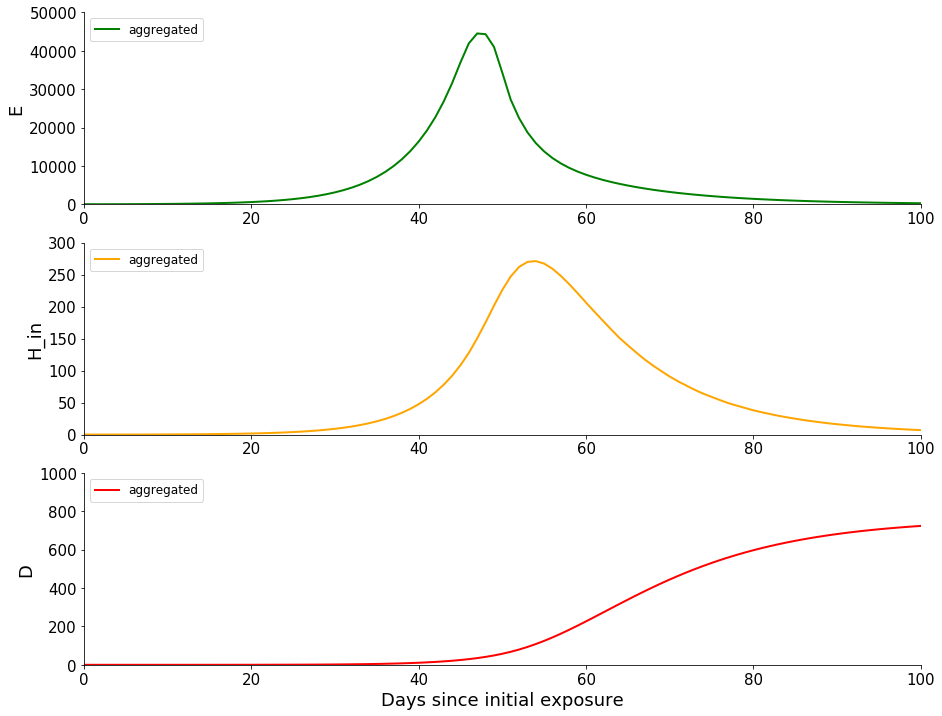

In [182]:
out_prov_det = model.sim(days_number)
graphs = show_graphs(out_prov_det, ylim=[50000, 300, 1000], ts=['E', 'H_in', 'D'])

## Spatial deterministic: arrondissements

In [10]:
# Load parameters and interaction matrices
age_str = True
spatial_str = 'arr'
intensity='all'

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

days_number = 100

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number
tau = 5 # days until new measures show some effect
l = 5 # days since policy_time + tau until new measures show full effect

initN.shape

(43, 9)

In [11]:
# Define initial conditions

# Drop a single exposed 35-year-old in each arrondissement
exposed = np.zeros(initN.shape)
exposed[3,3] = 43

init_states = dict({'S' : initN, 'E' : exposed})

# The type of policy change: contact is reduced from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

# # Extra: change mobility matrix: (fraction) of people that stay at home are now spread over the rest of the possible destinations
# G = initN.shape[0]
# fraction = 1/2
# for gg in range(G):
#     diag = place[gg][gg]
#     place[gg][gg] = place[gg][gg] * fraction
#     for hh in range(G):
#         value = diag*fraction / (G-1)
#         if gg != hh:
#             place[gg][hh] = place[gg][hh] + value
    
# params.update({'place' : place})

# params.update({'pi' : np.zeros(initN.shape[1])})
params['pi']

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
# Load the model
model = models.COVID19_SEIRD_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=False, spatial=spatial_str)

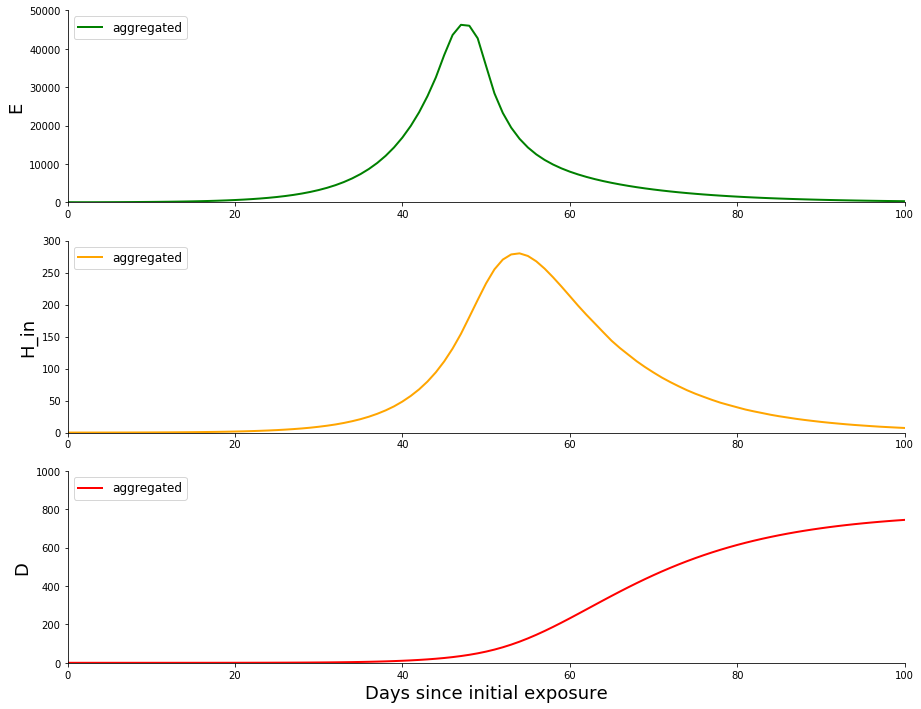

In [13]:
out_arr_det = model.sim(days_number)
graphs = show_graphs(out_arr_det, ylim=[50000, 300, 1000], ts=['E', 'H_in', 'D'])
# for day in range(days_number):
#     maps = show_map(out_arr_det, arrondissements, day=day, ts_graph=None, figname=f'no-mobility_day{str(day)}')

In [186]:
show_map?

## Spatial deterministic - focus on single patch without mobility (sanity check)

In [93]:
# Load parameters and interaction matrices
age_str = True
spatial_str = 'prov'
intensity='all'

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

days_number = 100

# Policy values (for more details on nature of measures, see block below)
policy_time = 40 # Must be smaller than days_number
tau = 5 # days until new measures show some effect
l = 5 # days since policy_time + tau until new measures show full effect

In [78]:
# Define initial conditions

# Artificially fill up Brussels with entire Belgian population and bring mobility to zero and drop all exposed people there

# Drop a single exposed 35-year-old in each arrondissement + the same number as nationally in Brussels
exposed = np.zeros(initN.shape)
exposed[:,3] = 0
exposed[3,3] = 43

initN_pseudo = initN.copy()
initN_pseudo[3] = np.sum(initN, axis=0)

init_states = dict({'S' : initN_pseudo, 'E' : exposed})

params.update({'pi' : np.zeros(initN.shape[1])})

# The type of policy change: contact is reduced from everything to home contact (within the arrondissement) only
policy1 = Nc_total
policy2 = Nc_home
params.update({'policy1' : policy1,
               'policy2' : policy2})

# Add social policy parameter values
params.update({'l': l,
              'tau': tau,
              'policy_time' : policy_time})

params['beta']

0.03492

In [79]:
# Load the model
model = models.COVID19_SEIRD_spatial(init_states, params, time_dependent_parameters={'Nc' : social_policy_func},
                                     discrete=False, spatial=spatial_str)

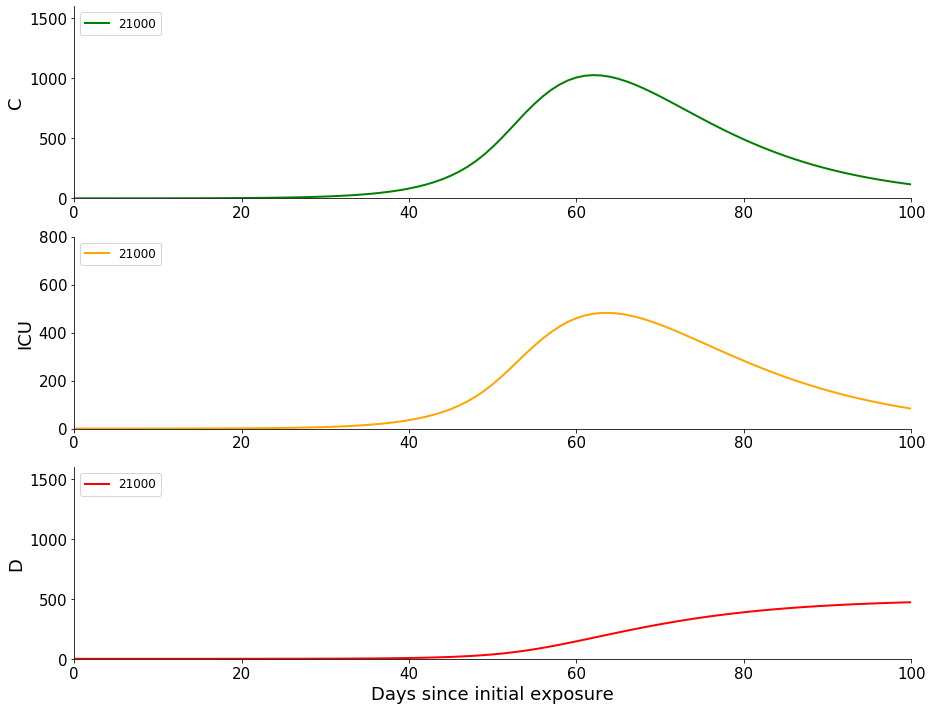

In [75]:
out_spat_det_pseudo = model.sim(days_number)
graphs = show_graphs(out_spat_det_pseudo, ts=['C', 'ICU', 'D'], ylim=[1600, 800, 1600],  nis=21000)

In [46]:
out_spat_det_pseudo['D'].sel(place=21000).sum(dim='Nc')

<xarray.DataArray 'D' (time: 101)>
array([0.00000000e+00, 3.71178226e-09, 3.80933575e-07, 5.22138257e-06,
       3.17882582e-05, 1.23205919e-04, 3.63816052e-04, 8.86086470e-04,
       1.88120820e-03, 3.61151969e-03, 6.39786847e-03, 1.06329183e-02,
       1.67955108e-02, 2.54478330e-02, 3.72296274e-02, 5.28935491e-02,
       7.33158377e-02, 9.95005274e-02, 1.32614125e-01, 1.74017194e-01,
       2.25303047e-01, 2.88324205e-01, 3.65244082e-01, 4.58622302e-01,
       5.71461015e-01, 7.07282645e-01, 8.70234824e-01, 1.06525326e+00,
       1.29812583e+00, 1.57566596e+00, 1.90596008e+00, 2.29860257e+00,
       2.76486281e+00, 3.31802086e+00, 3.97390576e+00, 4.75120009e+00,
       5.67191023e+00, 6.76199735e+00, 8.05242057e+00, 9.57956707e+00,
       1.13863247e+01, 1.35235726e+01, 1.60515562e+01, 1.90411736e+01,
       2.25758498e+01, 2.67550027e+01, 3.16949519e+01, 3.75344232e+01,
       4.44323093e+01, 5.25627763e+01, 6.21125934e+01, 7.32491175e+01,
       8.61061086e+01, 1.00766627e+02, 1.17237153e+02, 1.35446830e+02,
       1.55272844e+02, 1.76536734e+02, 1.99027703e+02, 2.22509193e+02,
       2.46743294e+02, 2.71496603e+02, 2.96538188e+02, 3.21656196e+02,
       3.46666044e+02, 3.71398291e+02, 3.95705823e+02, 4.19468068e+02,
       4.42584890e+02, 4.64974808e+02, 4.86575464e+02, 5.07341125e+02,
       5.27240464e+02, 5.46254460e+02, 5.64374827e+02, 5.81603053e+02,
       5.97947716e+02, 6.13423495e+02, 6.28050892e+02, 6.41853895e+02,
       6.54859283e+02, 6.67096823e+02, 6.78597652e+02, 6.89393507e+02,
       6.99517076e+02, 7.09001305e+02, 7.17878598e+02, 7.26180992e+02,
       7.33940044e+02, 7.41186284e+02, 7.47949272e+02, 7.54257602e+02,
       7.60138651e+02, 7.65618613e+02, 7.70722524e+02, 7.75474168e+02,
       7.79896114e+02, 7.84009764e+02, 7.87835339e+02, 7.91391905e+02,
       7.94697445e+02])
Coordinates:
  * time     (time) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
    place    int64 21000

# scratches

In [161]:
# Load parameters and interaction matrices
age_str = True
spatial_str = 'arr'
intensity='all'

params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=age_str, spatial=spatial_str)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity=intensity, spatial=spatial_str)

Nc = Nc_total.copy()
place = params['place'].copy()
pi = params['pi'].copy()
area = params['area'].copy()
xi = params['xi']
N = initN.shape[1]
G = place.shape[0]

pi = np.zeros(N)

T = initN
# for key in ['S', 'E', 'I', 'A', 'M', 'ER', 'C', 'C_icurec', 'ICU', 'R']:
#     T += out_arr_det[key]
# # plt.plot(T.sum(dim='place').sum(dim='Nc'))

G = place.shape[0] # spatial stratification
N = Nc.shape[0] # age stratification
T_eff = np.zeros([G,N]) # initialise
for g in range(G):
    for i in range(N):
        sumT = 0
        # h is taken, so iterator for a sum is gg
        for gg in range(G):
            term1 = (1 - pi[i]) * np.identity(G)[gg][g]
            term2 = pi[i] * place[gg][g]
            sumT += (term1 + term2) * T[gg][i]
        T_eff[g][i] = sumT      

# Density dependence per patch: f[patch]
T_eff_total = T_eff.sum(axis=1)

rho = np.zeros(G)
for gg in range(G):
    rho[gg] = T_eff_total[gg] / area[gg]
f = 1 + (1 - np.exp(-xi * rho))

# Normalisation factor per age class: zi[age]
# Population per age class
Ti = T.sum(axis=0)
zi = np.zeros(N)
for i in range(N):
    denom = 0
    for gg in range(G):
        denom += f[gg] * T_eff[gg][i]
    zi[i] = Ti[i] / denom
        
prefactor = np.zeros([G,N])
for gg in range(G):
    for ii in range(N):
        prefactor[gg,ii] = zi[ii] * f[gg]

Text(0.5, 1.05, 'prefactors when $p_i = 0$')

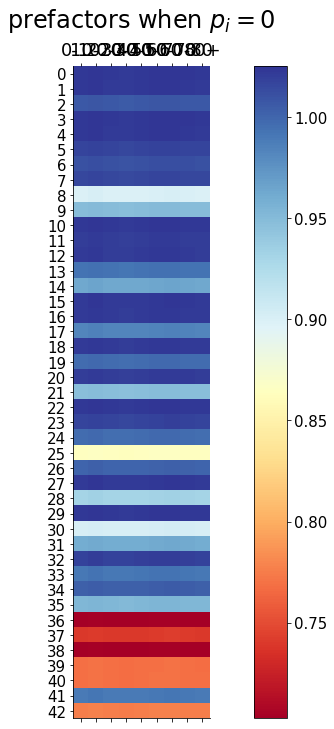

In [163]:
from matplotlib import ticker

fontsize = 18
day = 0
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.grid(False)
cax = ax.matshow(prefactor[:,:,day],cmap='RdYlBu')#, vmin=0.7, vmax=1.05)
fig.colorbar(cax)
# ax.set_ylabel('test')
# ax.set_xticklabels(['dummy', '10000', '20001', '20002', '21000', '30000', '40000', '50000', '60000', '70000', '80000', '90000'], fontsize=fontsize)
ax.set_xticklabels(['dummy', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'], fontsize=fontsize)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_title(f'prefactors when $p_i = 0$', fontsize=fontsize+6)
# plt.savefig('prefactor-evolution_' + str(day) + '.png')
# plt.close()

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

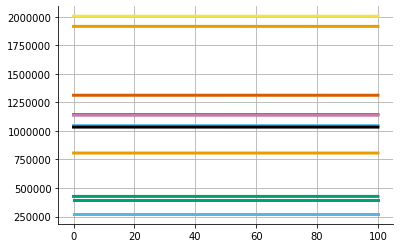

In [141]:
for gg in range(G):
    plt.plot(np.sum(T_eff,axis=1)[gg])
    
pi

## Checking where the model goes wrong

In [15]:
params = model_parameters.get_COVID19_SEIRD_parameters(age_stratified=True, spatial=False)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(intensity='all', spatial=False)

I = 10*np.ones(initN.shape[0])
A = 20*np.ones(initN.shape[0])
T = initN

result1 = np.matmul(Nc_total,((I+A)/T))

result2 = np.zeros(initN.shape[0])
for i in range(initN.shape[0]):
    sumj = 0
    for j in range(initN.shape[0]):
        term = Nc_total[i,j] * (I[j] + A[j]) / T[j]       # Nc[j,i] ?
        #term = beta * s[i] * Nc[i,j] * (I_eff[gg,j] + A_eff[gg,j]) / T_eff[gg,j]
        sumj += term
    result2[i] = sumj

print(result1)
result2

[0.000354   0.00046238 0.00044196 0.00049832 0.00048071 0.00037919
 0.00024645 0.0001974  0.00018163]


array([0.000354  , 0.00046238, 0.00044196, 0.00049832, 0.00048071,
       0.00037919, 0.00024645, 0.0001974 , 0.00018163])